## Evolution Strategies: Atari

![img](https://t4.ftcdn.net/jpg/00/17/46/81/240_F_17468143_wY3hsHyfNYoMdG9BlC56HI4JA7pNu63h.jpg)

[The paper about the algorithm](https://arxiv.org/abs/1703.03864)

In this notebook you should train an agent for one of the simplest and popular Atari game: Pong!

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


### N-grams

A single grame of Atari doesn't contain all the necessary information about the environment state.
We deal with this problem by using 4-frame buffers instead of single frames as input. This is a common trick for so-called "partially observable" environments if you don't want to use RNNs. At first you are going to implement this small hack.

We help you a little bit by setting a good crop and resize so the image will be significantly smaller but the agent will still have all the information.

### Installation of atari:
You have to run `pip install --upgrade gym[atari]==0.19` on your local machine. If you have some problems with the installation, please ask your classmates or google the error message.

In [2]:
!pip install --upgrade gym[atari]==0.19

You should consider upgrading via the '/home/d00435111/venvs/py3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
import time
from copy import deepcopy
import multiprocessing 
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.nn.functional as F

from joblib import Parallel, delayed
from IPython.display import clear_output
from IPython import display

torch.set_num_threads(1)

%matplotlib inline

In [2]:
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2

def make_pong():
    """creates breakout env with all preprocessing done for you"""
    return PreprocessAtari(gym.make("PongDeterministic-v0"))

class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, crop=lambda img: img[34:34 + 160], n_frames=4):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (height, width)
        self.crop = crop
        
        self.num_frames = 0
        self.state = torch.zeros((n_frames, height, width))
        
        self.total_reward = 0
        self.n_frames = n_frames
        self.env = env
        
    def reset(self):
        """resets breakout, returns initial frames"""
        self.state = torch.zeros(self.n_frames, self.img_size[0], self.img_size[1])
        s = self.env.reset()
        self.total_reward = 0
        self.num_frames = 0
        return self.state

    @torch.no_grad()
    def step(self, action):
        """plays breakout for 1 step, returns 4-frame buffer"""
        
        step_reward = 0
        frame, reward, done, info = self.env.step(action)
        img = self.preproc_image(frame, self.img_size, self.crop)
        self.num_frames += 1
        if self.num_frames < self.n_frames:
            for f in range(self.num_frames-1, self.n_frames):
                self.state[f,...] = torch.tensor(img)
        else:
            c = self.state.clone().detach()
            for i in range(self.n_frames - 1):
                self.state[i] = c[i+1]
            
            self.state[-1,...] = torch.tensor(img)   
        
        step_reward += reward
        self.total_reward += step_reward        
        return done, step_reward
    
    ###image processing###

    def update_buffer(self, img):
        pass

    @staticmethod
    def preproc_image(img, img_size, crop):
        """what happens to the observation"""
        img = crop(img)
        img = cv2.resize(src=img,
                       dsize=img_size,
                       interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = cv2.resize(src=img,
        #               dsize=img_size,
        #               interpolation=cv2.INTER_CUBIC).mean(-1)
        img = img.astype('float32') / 255.
        img -= np.mean(img)
        img /= np.std(img)
        return img

In [3]:
env = make_pong()
print("Action space:", env.action_space)
state_size = env.observation_space.shape
n_actions = env.action_space.n
print(state_size)
#env.render()

Action space: Discrete(6)
(210, 160, 3)


In [4]:
@torch.no_grad()
def display_session(env, agent, t_max=100):
    total_reward = 0
    plt.figure(figsize=(4, 3))
    display.clear_output(wait=True)

    s = torch.tensor(env.reset())
    for t in range(t_max):
        plt.gca().clear()
        
        a = agent.get_action(torch.tensor(s).float())
        done, step_reward = env.step(a)
        total_reward += step_reward
        
        # Draw game image on display.
        plt.imshow(env.env.render('rgb_array'))

        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        if done:
            break
            
    return total_reward

In [6]:
def generate_session(env, agent, t_max=500, p=1):
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(s.float())
        done, r = env.step(a)
        total_reward += r
        s = env.state
        
        if done:
            break
            
    return total_reward

def score(env, agent, n=20, t_max=10000):
    rewards = [generate_session(env, agent, t_max) for _ in range(n)]
    return np.mean(rewards)

### The challenge
Feel free to use everything you did at the seminar. 

If you achieve average score -10, it's the success!

In [8]:
from copy import deepcopy

def add_noise_to_model(model, noise, copy=False):
    if copy:
        model = deepcopy(model)
        
    for param, noise_p in zip(model.parameters(), noise):
        param.data += torch.tensor(noise_p)
        
    return model

In [9]:
from pathos.multiprocessing import ProcessingPool as Pool
import warnings


def f(noised_models, manager, p):
    reward = score(manager.env, noised_models[p], manager.n_score, t_max=manager.t_max)
    return reward


class EvolutionManager:
    def __init__(self, lr=0.001, std=0.01, n_samples = 64, 
                 n_score=10, t_max=500, normalize=True, num_processes=6, use_mirroring=False):
        super().__init__()
        
        self.lr = lr
        self.std = std
        self.n_score=n_score 
        self.t_max=t_max
        
        self.normalize = normalize
        self.n_samples = n_samples
        
        self.mean_reward_history = []
        
        self.env = make_pong()
        
        self.num_processes = num_processes
        self.use_mirroring = use_mirroring
        
        if use_mirroring and n_samples % 2 == 1:
            warnings.warn("Warning: odd number of samples")
        
    def get_noised_model(self, model):
        noise = [self.std * np.random.randn(*p.shape) for p in model.parameters()]
        return add_noise_to_model(model, noise, copy=True), noise

    def optimize(self, model, noises, rewards):
        total_noise = []
        for (i, p) in enumerate(model.parameters()):
            total_noise.append(np.zeros(p.shape))
            for noise, r in zip(noises, rewards):
                total_noise[-1] += r * noise[i] / (self.std**2) * self.lr / len(noises)
        add_noise_to_model(model, total_noise, copy=False) 
        print(np.mean(total_noise[0]), np.mean(np.abs(total_noise[0])))
    
    def step(self, model):
        rewards = []
        noises = []
        noised_models = []
        
        if self.use_mirroring:
            for i in range(self.n_samples):
                if i % 2 == 1:
                    noise = deepcopy(noises[-1])
                    for j in range(len(noise)):
                        noise[j] = -noise[j]
                    noised_model = add_noise_to_model(model, noise, copy=True)
                    noised_models.append(noised_model)
                    noises.append(noise)
                else:
                    noised_model, noise = self.get_noised_model(model)
                    noised_models.append(noised_model)
                    noises.append(noise)
        else:
            for i in range(self.n_samples):
                noised_model, noise = self.get_noised_model(model)
                noised_models.append(noised_model)
                noises.append(noise)
            
        parallel_function = partial(f, noised_models, self)
        pool = Pool(processes=self.num_processes)
        result = pool.map(parallel_function, range(self.n_samples))
            
        for reward in result:
            rewards.append(reward)
            
        rewards = np.array(rewards)
        scores = rewards.copy()
        self.update_log(rewards)
        if self.normalize:
            rewards -= np.mean(rewards)
            rewards /= np.std(rewards) + 1e-3
        
        self.optimize(model, noises, rewards)
        return scores
        
    def update_log(self, rewards):
        mean_reward = np.mean(rewards)
        self.mean_reward_history.append(mean_reward)

        clear_output(True)
        print("last mean reward = %.3f" % mean_reward)
        plt.figure(figsize=[8, 4])
        plt.subplot(1, 2, 1)
        plt.plot(self.mean_reward_history, label='Mean rewards')
        plt.legend()
        plt.grid()

        plt.subplot(1, 2, 2)
        plt.hist(rewards)
        plt.grid()

        plt.show()

In [10]:
class ConvNormPolicy(nn.Module):
    def __init__(self, n_actions, n_filters=32, kernel_size=11):
        super().__init__()
        self.n_actions = n_actions
        
        self.conv = nn.Conv2d(4, n_filters, kernel_size=kernel_size, 
                      stride=1, 
                      padding=0,
                      bias=False)
        
        self.fc = nn.Linear(64 * 16 * n_filters, n_actions, bias=False)
        self.relu = nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.last_action = None
        self.time = 0
            
    def forward(self, x):
        x -= torch.mean(x, dim=1)
        x /= torch.std(x) + 1e-5
        x = self.conv(x)
        x -= torch.mean(x, dim=1)
        x /= torch.std(x) + 1e-5
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
     
    @torch.no_grad()
    def get_action(self, state):
        self.time += 1
        #if self.time % 4 == 0:
        #    return self.last_action
        
        res = self.forward(state.unsqueeze(0))[0]
        res = int(torch.argmax(res).numpy())
        self.last_action = res
        return res

In [11]:
tmp_env = make_pong()
n_states = tmp_env.observation_space.shape[0]
n_actions = tmp_env.action_space.n

In [12]:
model = ConvNormPolicy(n_actions, n_filters=10)
model

ConvNormPolicy(
  (conv): Conv2d(4, 10, kernel_size=(11, 11), stride=(1, 1), bias=False)
  (fc): Linear(in_features=10240, out_features=6, bias=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

Комментарий: я экспериментировал с разными архитектурами, но лучше всего работала такая простая архитектура с нормализациями.

In [14]:
def train(num_epoch, experiment_name, lr=0.001, std=0.01, n_samples = 64, n_score=5, t_max=10000, normalize=True):
    algorithm = EvolutionManager(lr=lr, std=std, n_samples=n_samples, 
                                 n_score=n_score, t_max=t_max, normalize=normalize, num_processes=32)
    best_result = -float('inf')
    for i in range(num_epoch):
        t = time.time()
        result = algorithm.step(model)
        result = np.mean(result)
        if result > best_result:
            best_result = result
            torch.save(model.state_dict(), 'atari_model_%s.ckpt' % experiment_name)
        print(time.time() - t)

Комментарий: я учил модель несколько раз, поэтому здесь несколько графиков.

last mean reward = -19.630


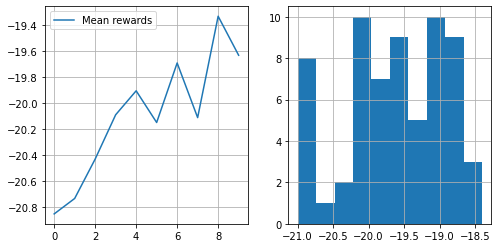

0.00027820559174397805 0.01009244301417122
192.7763204574585


In [15]:
train(10, 'conv_bn_model', lr=0.001, std=0.01, n_samples=64, n_score=10, t_max=10000, normalize=True)

last mean reward = -16.962


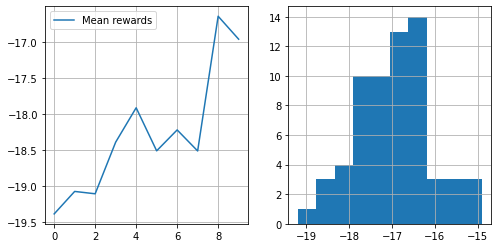

-1.880360372272578e-05 0.010098997707607442
257.6455509662628


In [16]:
train(10, 'conv_bn_model', lr=0.001, std=0.01, n_samples=64, n_score=10, t_max=10000, normalize=True)

last mean reward = -9.545


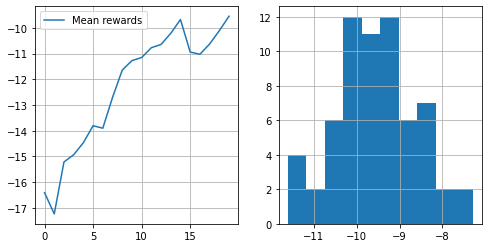

9.027309186367415e-05 0.00978328373628282
387.0937786102295


In [17]:
train(20, 'conv_bn_model', lr=0.001, std=0.01, n_samples=64, n_score=10, t_max=10000, normalize=True)

last mean reward = -4.550


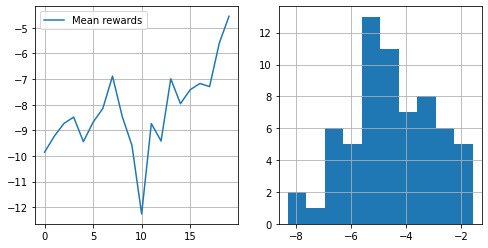

6.648080913080389e-05 0.009988774554929122
452.84363174438477


In [18]:
train(20, 'conv_bn_model', lr=0.001, std=0.01, n_samples=64, n_score=10, t_max=10000, normalize=True)

In [19]:
score(env, model, n=100, t_max=10000)

-3.31

last mean reward = -7.289


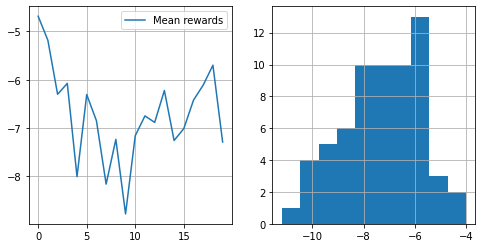

-0.00014625219243665573 0.00986581802891273
419.00184535980225


In [20]:
train(20, 'conv_bn_model', lr=0.001, std=0.01, n_samples=64, n_score=10, t_max=10000, normalize=True)

In [21]:
score(env, model, n=100, t_max=10000)

-3.17

In [22]:
score(env, model, n=1000, t_max=10000)

-3.911

По результатам 1000 игр средний счет -3.991.